In [1]:
# Import image processing libraries

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
# Auxiliar functions

def save_image(img, name):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(name, img)

def plot_image(img, title):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(title), plt.axis('off')
    plt.show()

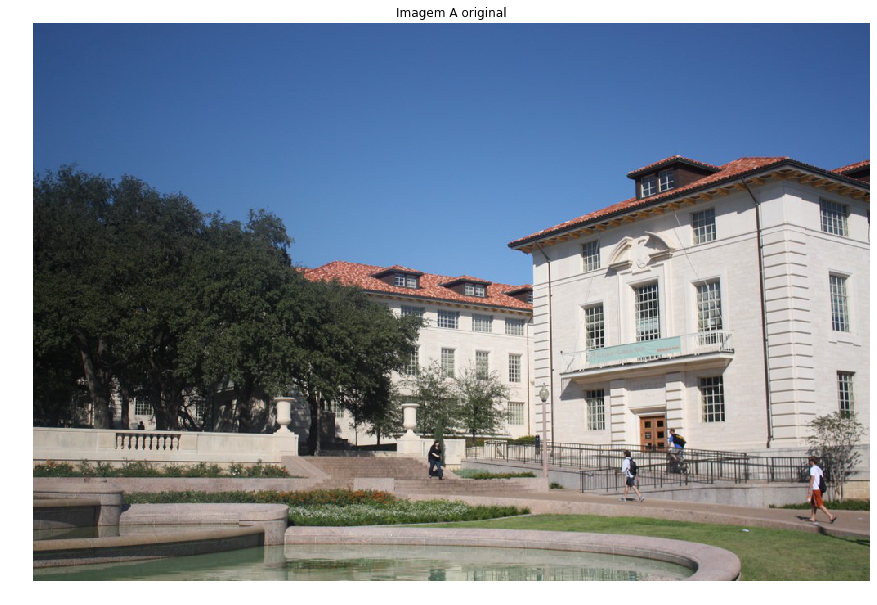

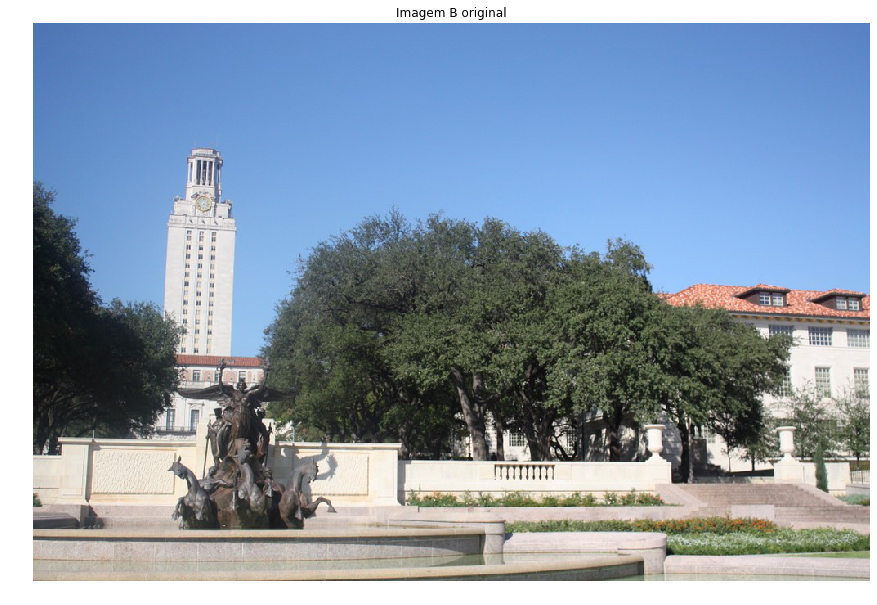

In [3]:
# Load the iamges and set the properly clors

IMAGE_FILE_1 = "images/foto1A.jpg"
IMAGE_FILE_2 = "images/foto1B.jpg"

imageA = cv2.imread(IMAGE_FILE_1)
imageB = cv2.imread(IMAGE_FILE_2)

plt.rcParams["figure.figsize"] = (15,15)
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)

images = (imageB, imageA)

plot_image(imageA, "Imagem A original")
plot_image(imageB, "Imagem B original")

In [4]:
def detectKeyfeatures(image, desc_type=None):
    '''Uses different algorithm to detect keypoints'''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if desc_type == 1:
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif desc_type == 2:
        descriptor = cv2.xfeatures2d.SURF_create()
    else:
        descriptor = cv2.ORB_create()
    
    (points, features) = descriptor.detectAndCompute(image, None)

    return (points, features)

In [5]:
def matchKeypoints(dataA, dataB, ratio):
    '''Match keypoints due to a ratio pass as parameter'''
    (pointsA, featuresA) = dataA
    (pointsB, featuresB) = dataB

    # Brute force method
    matcher = cv2.BFMatcher()
    all_matches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    for (m,n) in all_matches:
        if m.distance < n.distance * ratio:
            matches.append([m])
    
    return matches

In [6]:
def calculateHomography(pointsA, pointsB, matches):
    '''Calculate the Homography based in at least 4 matches, return None if impossible'''
    if len(matches) > 4:
        
        ptsA = np.float32([pointsA[m[0].queryIdx].pt for m in matches])
        ptsB = np.float32([pointsB[m[0].trainIdx].pt for m in matches])

        (H, mask) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)

        return (H, mask)
    return None

In [7]:
def panoramic(leftImage, rightImage, desc_type=None, ratio=0.75):
    '''Calcultate the panoramic, giving the left and right image, return the Homography matrix'''
    dataRight = detectKeyfeatures(rightImage, desc_type)
    dataLeft = detectKeyfeatures(leftImage, desc_type)
    
    matches = matchKeypoints(dataRight, dataLeft, ratio)
    (H, mask) = calculateHomography(dataRight[0], dataLeft[0], matches)

    # write the rght image in the result image
    result = cv2.warpPerspective(rightImage, H,
        (rightImage.shape[1] + leftImage.shape[1], max(rightImage.shape[0], leftImage.shape[0]) ))

    # write the left image into the result
    result[0:leftImage.shape[0], 0:leftImage.shape[1]] = leftImage
    plot_image(result, "Panoramic image")
    save_image(result, 'result.jpeg')

    # Plot the relation between the two images
    relation_image =  cv2.drawMatchesKnn(rightImage,dataRight[0],leftImage,dataLeft[0],matches,None,flags=2)
    plot_image(relation_image, "Relaton betweeen keypoints")
    
    save_image(relation_image, 'relation.jpeg')

    return H

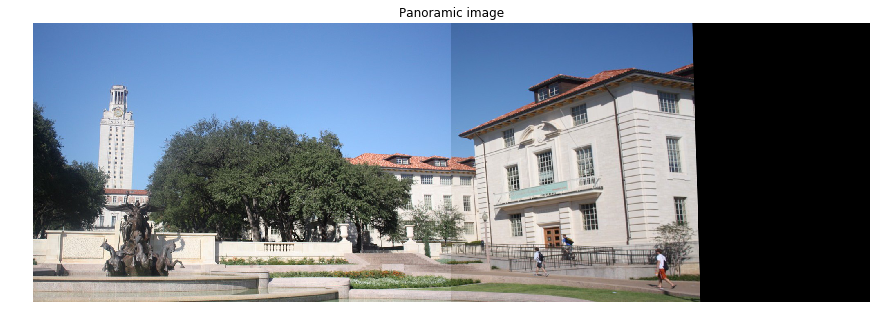

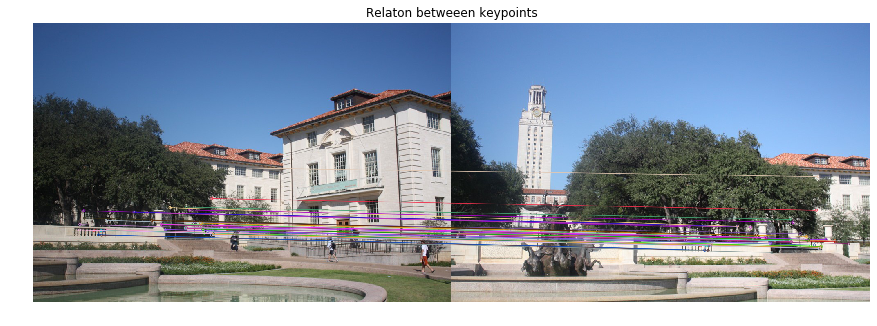

[[ 8.04085627e-01  1.14368959e-01  4.26827757e+02]
 [-1.38270474e-01  1.00611847e+00  5.16848063e+01]
 [-2.18235151e-04  5.26803170e-05  1.00000000e+00]]


In [11]:
print(panoramic(imageB, imageA))

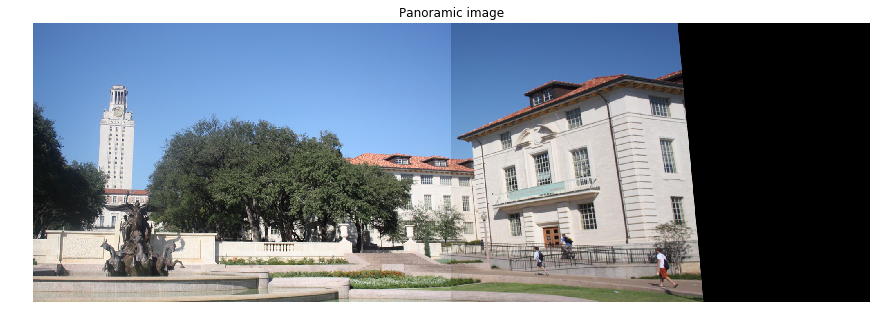

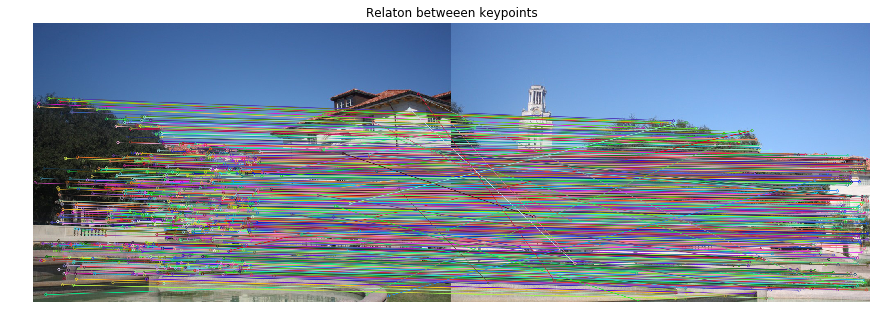

[[ 7.68738594e-01  3.90287161e-02  4.46182347e+02]
 [-1.34744502e-01  9.14576387e-01  7.55427524e+01]
 [-2.09189490e-04 -2.96823608e-05  1.00000000e+00]]


In [12]:
print(panoramic(imageB, imageA, 1))

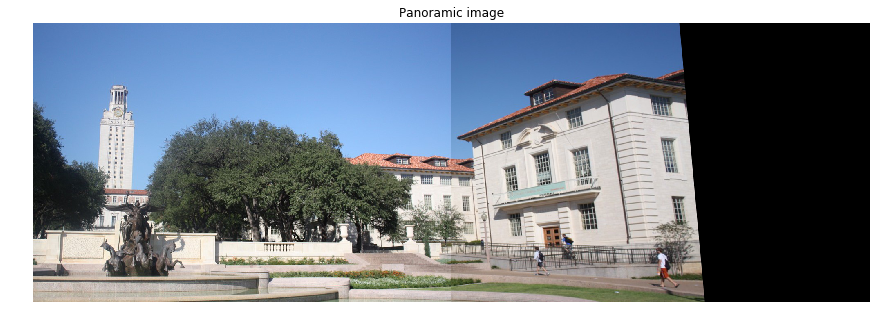

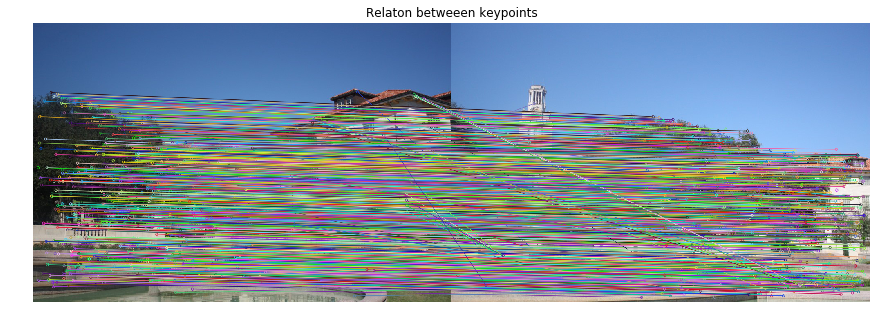

[[ 7.63036442e-01  4.36670504e-02  4.46016611e+02]
 [-1.37828743e-01  9.16552401e-01  7.58029832e+01]
 [-2.14949351e-04 -2.55767830e-05  1.00000000e+00]]


In [13]:
print(panoramic(imageB, imageA, 2))